In [26]:
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from aircraft import airplane
import propellers as prop

plt.style.use('../../basic_plotter.mplstyle')

# Simple aerodynamic Model of Vehicle
CD0 = 0.018         # Zero lift drag coefficient
k   = 0.03          # Induced drag coefficient (1/(pi*AR*e))

# Static conditions
rho0 = 1.225        # Standard seal level air density for now

createv = airplane(13.0, 0.395, 6.28)
createv_prop = prop.aeronaut185x12()

# Operating point variation
V_inf = np.linspace(8, 25.7, 30)      # Airspeed in meters per second to check operating point
throttle = np.linspace(0, 1, 20)       # Throttle as a floating fraction, for defining thrust as fraction of cruise thrust

# Meshing the inputs
V_INF_op, THROTTLE = np.meshgrid(V_inf, throttle)

# Calculating h dot from X and V
q = 0.5 * rho0 * V_INF_op**2
X_T_createv_cruise = (CD0 * q * createv.area) + (k * (q*createv.area)**-1 * createv.weight**2)
X_T_op = X_T_createv_cruise * THROTTLE
h_dot_op = (-X_T_createv_cruise * V_INF_op * createv.weight**-1) + (X_T_op * V_INF_op * createv.weight**-1)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_16245/806112873.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax1)


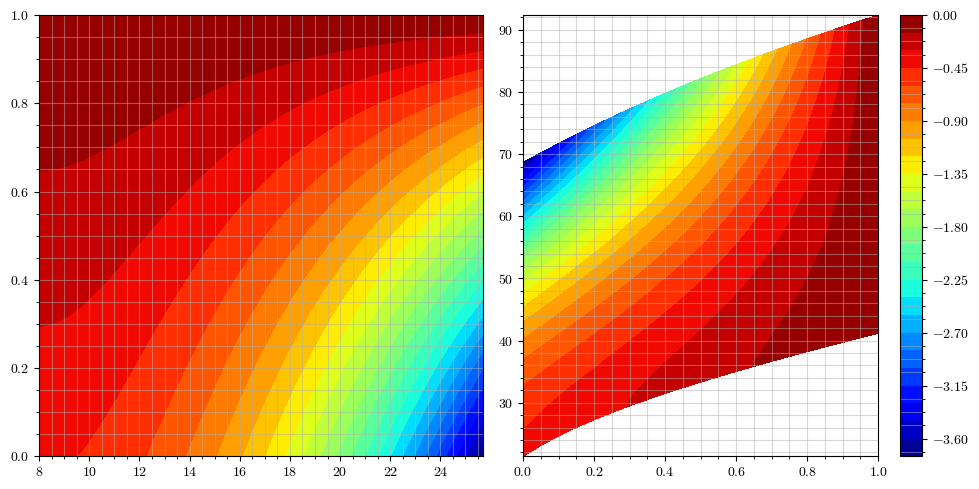

In [27]:
# Getting Estimates for propeller RPM
N_op = np.zeros(np.shape(V_INF_op))

for j, v in enumerate(V_inf):
    for i, x_t_createv in enumerate(X_T_op[:,j]):
        N_op[i, j] = createv_prop.getRPM(x_t_createv, rho0, v)

fig = plt.figure(figsize=(10,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.contourf(V_INF_op, THROTTLE, h_dot_op, cmap="jet", levels=30)
pcm = ax1.contourf(THROTTLE, N_op, h_dot_op, cmap="jet", levels=30)
fig.colorbar(pcm, ax=ax1)
plt.show()

Only required inputs are:  
* N_op
* X_T_op
* V_INF_op

In [28]:
from sympy import init_printing
from sympy import *
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget
plt.style.use('../../basic_plotter.mplstyle')
# Defining static conditions for cruise
[n_0, V_0, rho_0, C_D_0, X_T_0, h_dot_0]= symbols('n_0 V_0 \\rho_0 C_{D_0} X_{T_0} \dot{h}_0')
# rho_0 = 1.225

# Defining complete input variables
[V_T, V,  U_dot, W_dot, h_dot, theta, n, rho, D, m, g, S, P, T, X_T] = symbols('V_T V \dot{U} \dot{W} \\dot{h} \\theta n \\rho D m g S P T X_T')

# Defining outputs
[C_L, C_T, J, alpha] = symbols('C_D C_T J \\alpha')

dV = Symbol('\\Delta V')
dU_dot = Symbol('\\Delta \dot{U}')
dW_dot = Symbol('\\Delta \dot{W}')
dh_dot = Symbol('\\Delta \dot{h}')

dtheta = Symbol('\\Delta \\theta')
dn = Symbol('\\Delta n')
drho = Symbol('\\Delta \\rho')
dg = Symbol('\\Delta g')

## Defining the Operating Points at Cruise (For CREATeV)

Assumptions:
* No wind to speak of
* Perturbations happen one at a time, not all at once
* Cruising at conditions defined by some assumed drag polar
  * Drag Polar: $C_D = C_{D_0} + k C_L^2$
  * $C_{D_0} = 0.018$
  * $AR = \frac{b^2}{S} = 6.2V_op[i]^2 / (6.28 * 0.395) = 15.89$
  * $k = 1 / (\pi AR e) = 0.03$ (Assumption from range of polar results (0.029 to 0.0556))

In [29]:
# Defining Operating Points in Cruise (cruise_operatingpoints_working.ipynb)
# Based on 20x8 and CREATeV performance (cd0 = 0.018, k = 0.03)
area = 6.28 * 0.395
CL_alpha = np.array([12.02184177, -10.35785056])

## Complete Drag & Drag Equations

In [30]:
# Total Drag
C_D_total = (1/2 * rho * V_T**2 * S)**-1 * (-((U_dot+W_dot*alpha)*m) - (m * g * (-h_dot/V_T)) + X_T_0)
C_D_total

2.0*(X_{T_0} - m*(\alpha*\dot{W} + \dot{U}) + \dot{h}*g*m/V_T)/(S*V_T**2*\rho)

In [31]:
# Total Lift
C_L_total = (1/2 * rho * V_T**2 * S)**-1 * ( m* (U_dot*alpha - W_dot) + (m*g) - X_T_0*alpha )
C_L_total

2.0*(-X_{T_0}*\alpha + g*m + m*(\alpha*\dot{U} - \dot{W}))/(S*V_T**2*\rho)

In [32]:
C_D = (1/2 * rho * V_T**2 * S)**-1 * (-((U_dot+W_dot*alpha)*m) + (m * g * (-h_dot/V_T)) + X_T)
C_L = (1/2 * rho * V_T**2 * S)**-1 * ( m * (U_dot*alpha - W_dot) + (m * g) - X_T*alpha )


# Primary equation local operating point
C_D_0 = (0.5 * rho_0 * V_0**2 * S)**-1 * (X_T_0 + (m * g * (-h_dot_0*V_0**-1)))
C_L_0 = (0.5 * rho_0 * V_0**2 * S)**-1 * ((m * g))

In [33]:
C_D_0

2.0*(X_{T_0} - \dot{h}_0*g*m/V_0)/(S*V_0**2*\rho_0)

In [34]:
dC_D_dV = diff(C_D, V_T)
dC_D_dU_dot = diff(C_D, U_dot)
dC_D_dW_dot = diff(C_D, W_dot)
dC_D_dh_dot = diff(C_D, h_dot)
dC_D_dX_T = diff(C_D, X_T)
dC_D_dalpha = diff(C_D, alpha)

In [35]:
dC_D_dalpha

-2.0*\dot{W}*m/(S*V_T**2*\rho)

## Getting 1% Deviation Estimates

Taking the ratio of terms t1, representing the partial derivatives of CD with respect to each input variable, then 

In [36]:
per_diff = 0.05

C_D_base_vec = np.zeros(np.shape(V_INF_op))
C_L_base_vec = np.zeros(np.shape(V_INF_op))
AOA_base_vec = np.zeros(np.shape(V_INF_op))
theta_base_vec = np.zeros(np.shape(V_INF_op))

dV_vec = np.zeros(np.shape(V_INF_op))
dU_dot_vec = np.zeros(np.shape(V_INF_op))
dW_dot_vec = np.zeros(np.shape(V_INF_op))
dh_dot_vec = np.zeros(np.shape(V_INF_op))
dX_T_vec = np.zeros(np.shape(V_INF_op))
dalpha_vec = np.zeros(np.shape(V_INF_op))

for j, v in enumerate(V_inf):
    for i, x_t_createv in enumerate(X_T_op[:,j]):
        C_L_0_base = float(C_L_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (g, 9.807), (m, 13.0)]))
        C_D_0_base = float(C_D_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (X_T_0, x_t_createv), (h_dot_0, h_dot_op[i,j]), (g, 9.807), (m, 13.0)]))
        alpha_base = np.deg2rad(CL_alpha[0]*C_L_0_base**1 + CL_alpha[1])
        theta_base = alpha_base + np.arcsin(h_dot_op[i,j]/v)

        tdV = dC_D_dV.subs([(rho, 1.225), (h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base), (X_T, x_t_createv)])
        tdU_dot = dC_D_dU_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])
        tdW_dot = dC_D_dW_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])
        tdh_dot = dC_D_dh_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])
        tdX_T = dC_D_dX_T.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])
        tdalpha = dC_D_dX_T.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])

        # total_term = tdV*dV + tdU_dot*dU_dot + tdW_dot*dW_dot + tdh_dot*dh_dot + tdtheta*dtheta + tdn*dn + tdrho*drho + tdg*dg
        # total_term

        dV = float((-C_D_0_base * (per_diff)) / (tdV))
        dU_dot = float((-C_D_0_base * (per_diff)) / (tdU_dot))
        dW_dot = float((-C_D_0_base * (per_diff)) / (tdW_dot))
        dh_dot = float((-C_D_0_base * (per_diff)) / (tdh_dot))
        dX_T = ((-C_D_0_base * (per_diff)) / (tdX_T))
        dalpha = ((-C_D_0_base * (per_diff)) / (tdalpha))

        dV_vec[i,j] = np.abs(dV)
        dU_dot_vec[i,j] = np.abs(dU_dot)
        dW_dot_vec[i,j] = np.abs(dW_dot)
        dh_dot_vec[i,j] = np.abs(dh_dot)
        dX_T_vec[i,j] = np.abs(dX_T)
        dalpha_vec[i,j] = np.abs((180/np.pi)*dalpha)
        C_D_base_vec[i,j] = np.abs(C_D_0_base)
        C_L_base_vec[i,j] = np.abs(C_L_0_base)
        theta_base_vec[i,j] = np.rad2deg(theta_base)
        AOA_base_vec[i,j] = np.rad2deg(alpha_base)

result_list = [dU_dot_vec, dh_dot_vec, dalpha_vec, dW_dot_vec, dV_vec, dX_T_vec]
operatingpoint_list = [C_L_base_vec, THROTTLE, AOA_base_vec, C_D_base_vec, N_op, theta_base_vec]
operatingpoint_list_short = [C_L_base_vec, C_D_base_vec, AOA_base_vec, X_T_op]

oper_labels_short = ['$C_{L0}$', '$C_{D0}$', '$\\alpha_0$', '$T_0$']
oper_labels = ['$C_{L0}$', 'Throttle', '$\\alpha_0$', '$C_{D0}$', '$n_0$', '$\\theta_0$']
labels = ['$\Delta \dot{U}$', '$\Delta \dot{h}$', '$\Delta \\alpha$', '$\Delta \dot{W}$', '$\Delta V_T$', '$\Delta X_T$']

Figures for operating point calculations

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_16245/3853860662.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=axi, shrink=0.9)


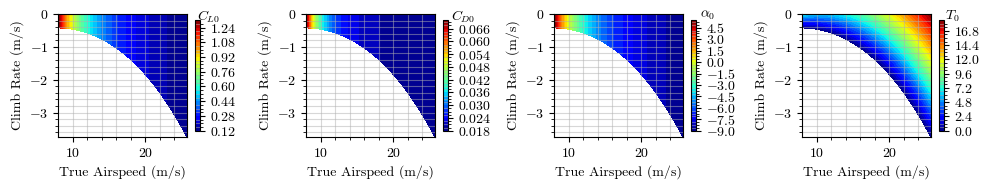

In [37]:
from matplotlib import colors
fig, axs = plt.subplots(1, 4, layout='tight')
fig.set_size_inches(10,2)
for i, axi in enumerate(axs.flat):
    pcm = axi.contourf(V_INF_op, h_dot_op, operatingpoint_list_short[i], cmap='jet', levels=30)
    fig.colorbar(pcm, ax=axi, shrink=0.9)
    pcm.colorbar.set_label(oper_labels_short[i], labelpad=-20, y=1.1, rotation=0)
    axi.set_xlabel("True Airspeed (m/s)")
    axi.set_ylabel("Climb Rate (m/s)")
    # cbar = fig.colorbar(pcm)
    # cbar.ax.set_title(oper_labels[i])   
plt.savefig("createv_sensitivity_oppoint.pdf")

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_16245/920171049.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax, shrink=0.9)


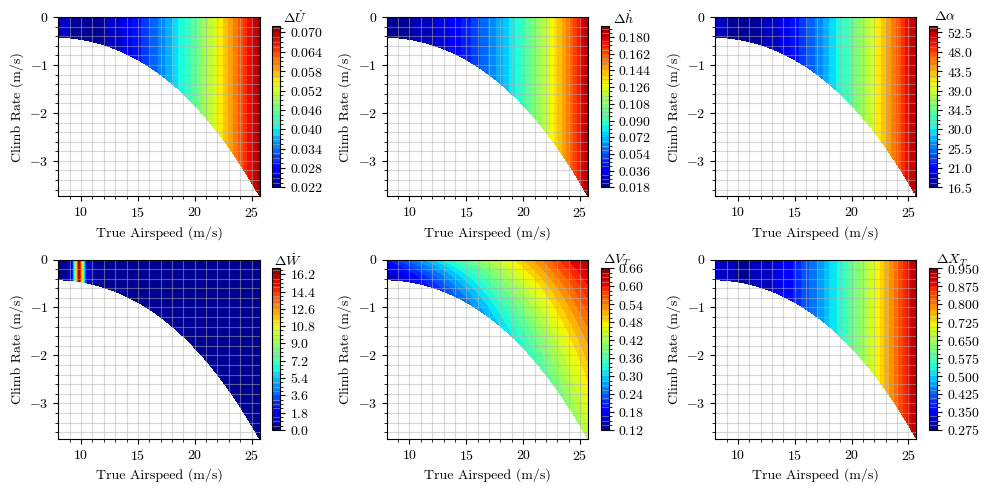

In [38]:
from matplotlib import colors
fig, axs = plt.subplots(2, 3, layout='tight')
fig.set_size_inches(10,5)
for i, ax in enumerate(axs.flat):
    pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=30)
    fig.colorbar(pcm, ax=ax, shrink=0.9)
    pcm.colorbar.set_label(labels[i], labelpad=-20, y=1.1, rotation=0)
    ax.set_xlabel("True Airspeed (m/s)")
    ax.set_ylabel("Climb Rate (m/s)")
    # cbar = fig.colorbar(pcm)
    # cbar.ax.set_title(oper_labels[i])   
plt.savefig("createv_sensitivity_CD.pdf")

# Lift Coefficient Sensitivity

In [39]:
dC_L_dV = diff(C_L, V_T)
dC_L_dU_dot = diff(C_L, U_dot)
dC_L_dW_dot = diff(C_L, W_dot)
dC_L_dh_dot = diff(C_L, h_dot)
dC_L_dX_T = diff(C_L, X_T)
dC_L_dalpha = diff(C_L, alpha)

In [40]:
C_L

2.0*(-X_T*\alpha + g*m + m*(\alpha*\dot{U} - \dot{W}))/(S*V_T**2*\rho)

In [41]:
C_L

2.0*(-X_T*\alpha + g*m + m*(\alpha*\dot{U} - \dot{W}))/(S*V_T**2*\rho)

In [42]:
per_diff = 0.05

C_D_base_vec = np.zeros(np.shape(V_INF_op))
C_L_base_vec = np.zeros(np.shape(V_INF_op))
AOA_base_vec = np.zeros(np.shape(V_INF_op))
theta_base_vec = np.zeros(np.shape(V_INF_op))

dV_vec = np.zeros(np.shape(V_INF_op))
dU_dot_vec = np.zeros(np.shape(V_INF_op))
dW_dot_vec = np.zeros(np.shape(V_INF_op))
dh_dot_vec = np.zeros(np.shape(V_INF_op))
dX_T_vec = np.zeros(np.shape(V_INF_op))
dalpha_vec = np.zeros(np.shape(V_INF_op))

for j, v in enumerate(V_inf):
    for i, x_t_createv in enumerate(X_T_op[:,j]):
        C_L_0_base = float(C_L_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (g, 9.807), (m, 13.0)]))
        C_D_0_base = float(C_D_0.subs([(rho_0, 1.225), (V_0, v), (S, area), (X_T_0, x_t_createv), (h_dot_0, h_dot_op[i,j]), (g, 9.807), (m, 13.0)]))
        alpha_base = np.deg2rad(CL_alpha[0]*C_L_0_base**1 + CL_alpha[1])
        theta_base = alpha_base + np.arcsin(h_dot_op[i,j]/v)

        tdV = dC_L_dV.subs([(rho, 1.225), (h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base), (X_T, x_t_createv)])
        tdU_dot = dC_L_dU_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])
        tdW_dot = dC_L_dW_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])
        tdh_dot = dC_L_dh_dot.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])
        tdX_T = dC_L_dX_T.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])
        tdalpha = dC_L_dX_T.subs([(h_dot, h_dot_op[i,j]), (S, area), (V_T, v), (rho, 1.225), (U_dot, 0), (W_dot, 0), (m, 13.0), (g, 9.807), (alpha, alpha_base)])

        dV = float((-C_L_0_base * (per_diff)) / (tdV))
        dU_dot = float((-C_L_0_base * (per_diff)) / (tdU_dot))
        dW_dot = float((-C_L_0_base * (per_diff)) / (tdW_dot))
        dh_dot = 999 #float((-C_L_0_base * (per_diff)) / (tdh_dot))
        dX_T = ((-C_L_0_base * (per_diff)) / (tdX_T))
        dalpha = ((-C_L_0_base * (per_diff)) / (tdalpha))

        dV_vec[i,j] = np.abs(dV)
        dU_dot_vec[i,j] = np.abs(dU_dot)
        dW_dot_vec[i,j] = np.abs(dW_dot)
        dh_dot_vec[i,j] = np.abs(dh_dot)
        dX_T_vec[i,j] = np.abs(dX_T)
        dalpha_vec[i,j] = np.abs((180/np.pi)*dalpha)
        C_D_base_vec[i,j] = np.abs(C_D_0_base)
        C_L_base_vec[i,j] = np.abs(C_L_0_base)
        theta_base_vec[i,j] = np.rad2deg(theta_base)
        AOA_base_vec[i,j] = np.rad2deg(alpha_base)

result_list = [dU_dot_vec, dh_dot_vec, dalpha_vec, dW_dot_vec, dV_vec, dX_T_vec]
operatingpoint_list = [C_L_base_vec, THROTTLE, AOA_base_vec, C_D_base_vec, N_op, theta_base_vec]
oper_labels = ['$C_{L0}$', 'Throttle', '$\\alpha_0$', '$C_{D0}$', '$n_0$', '$\\theta_0$']
labels = ['$\Delta \dot{U}$', '$\Delta \dot{h}$', '$\Delta \dot{\\alpha}$', '$\Delta \dot{W}$', '$\Delta V_T$', '$\Delta X_T$']

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_16245/1998329690.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=axi, shrink=0.9)


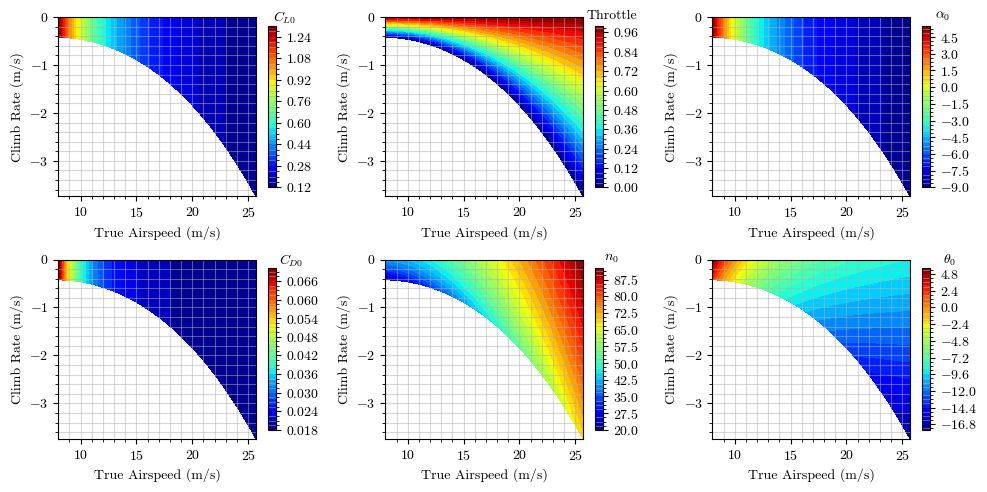

In [43]:
from matplotlib import colors
fig, axs = plt.subplots(2, 3, layout='tight')
fig.set_size_inches(10,5)
for i, axi in enumerate(axs.flat):
    pcm = axi.contourf(V_INF_op, h_dot_op, operatingpoint_list[i], cmap='jet', levels=30)
    fig.colorbar(pcm, ax=axi, shrink=0.9)
    pcm.colorbar.set_label(oper_labels[i], labelpad=-20, y=1.1, rotation=0)
    axi.set_xlabel("True Airspeed (m/s)")
    axi.set_ylabel("Climb Rate (m/s)")
    # cbar = fig.colorbar(pcm)
    # cbar.ax.set_title(oper_labels[i])   
# plt.savefig("createv_sensitivity_oppoint.pdf")

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_16245/2016118029.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax, shrink=0.9)
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\ti

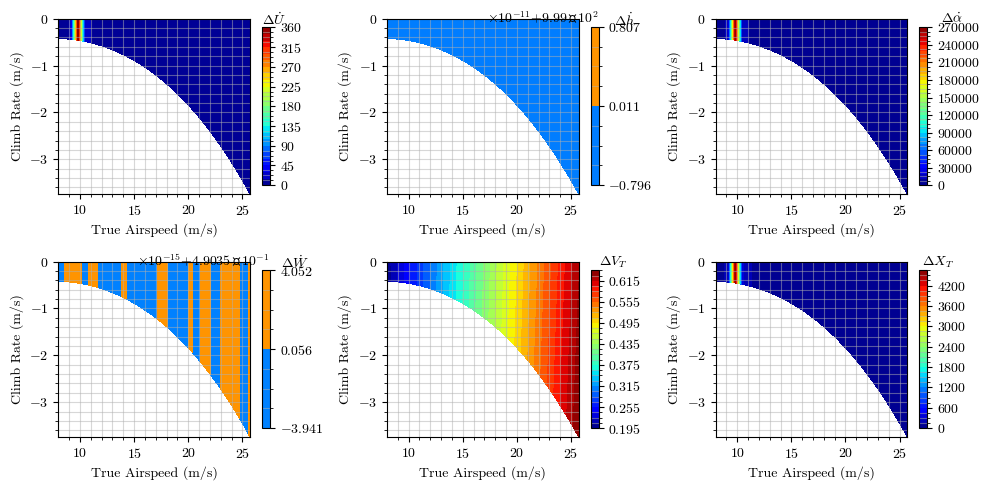

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


In [44]:
from matplotlib import colors
fig, axs = plt.subplots(2, 3, layout='tight')
fig.set_size_inches(10,5)
for i, ax in enumerate(axs.flat):
    pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=30)
    fig.colorbar(pcm, ax=ax, shrink=0.9)
    pcm.colorbar.set_label(labels[i], labelpad=-20, y=1.1, rotation=0)
    ax.set_xlabel("True Airspeed (m/s)")
    ax.set_ylabel("Climb Rate (m/s)")
    # cbar = fig.colorbar(pcm)
    # cbar.ax.set_title(oper_labels[i])   
plt.savefig("createv_sensitivity_CL.pdf")

[<AxesSubplot:> <AxesSubplot:>]
$\Delta \dot{U}$
$\Delta \dot{h}$
$\Delta \dot{\alpha}$
$\Delta \dot{W}$
$\Delta V_T$
$\Delta X_T$


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_16245/3806614668.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax)


IndexError: list index out of range

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

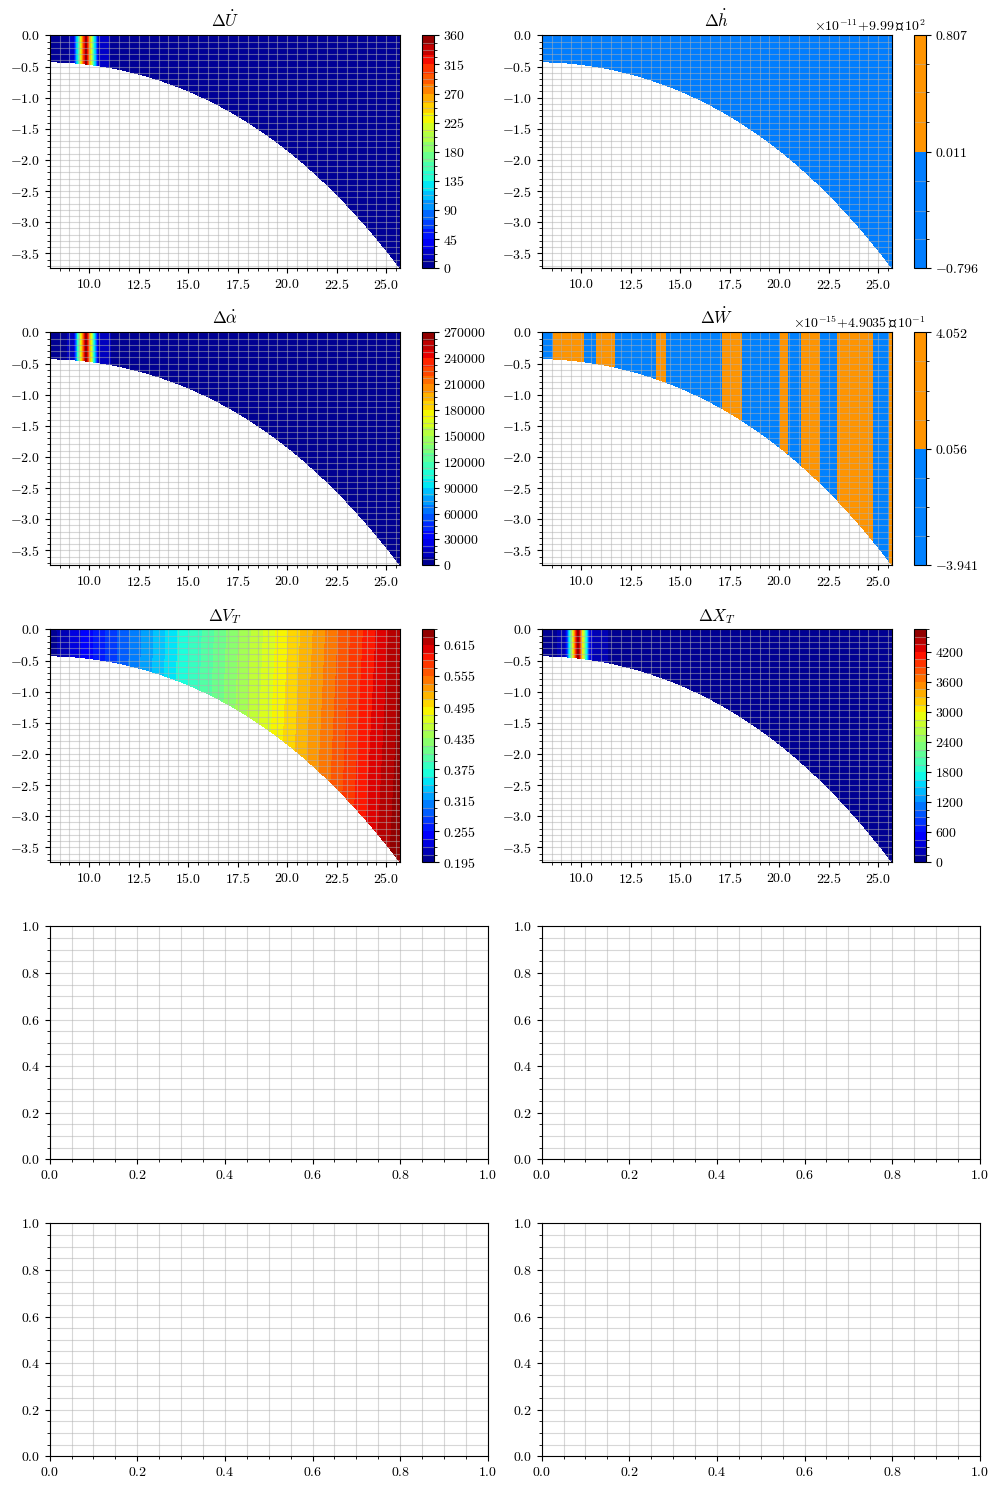

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


In [45]:
fig, axs = plt.subplots(5, 2, layout='tight')
print(axs[0])
fig.set_size_inches(10,15)
for i, ax in enumerate(axs.flat):
    pcm = ax.contourf(V_INF_op, h_dot_op, result_list[i], cmap='jet', levels=30)
    print(labels[i])
    ax.set_title(labels[i])
    fig.colorbar(pcm, ax=ax)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_42600/2766226519.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, ax=ax1)


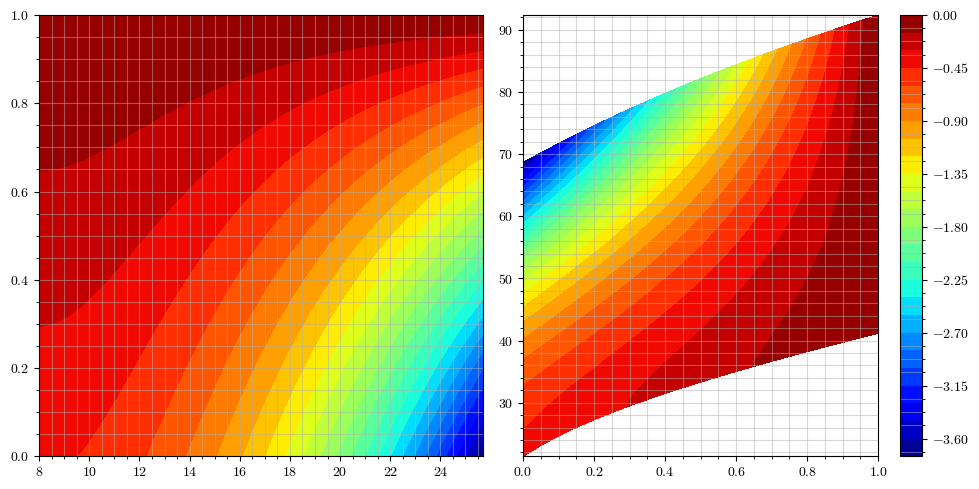

In [ ]:
fig = plt.figure(figsize=(10,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.contourf(V_INF_op, THROTTLE, h_dot_op, cmap="jet", levels=30)
pcm = ax1.contourf(THROTTLE, N_op, h_dot_op, cmap="jet", levels=30)
fig.colorbar(pcm, ax=ax1)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_42600/1611526574.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


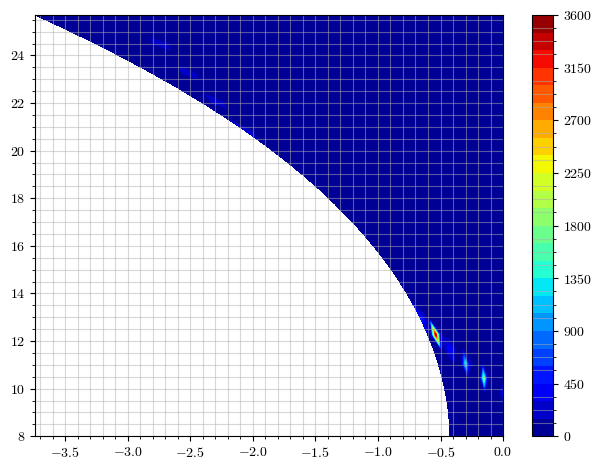

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


In [ ]:
plt.figure()
plt.contourf(h_dot_op, V_INF_op, drho_vec, cmap="jet", levels=30)
plt.colorbar()
plt.show()

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_42600/2788661297.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


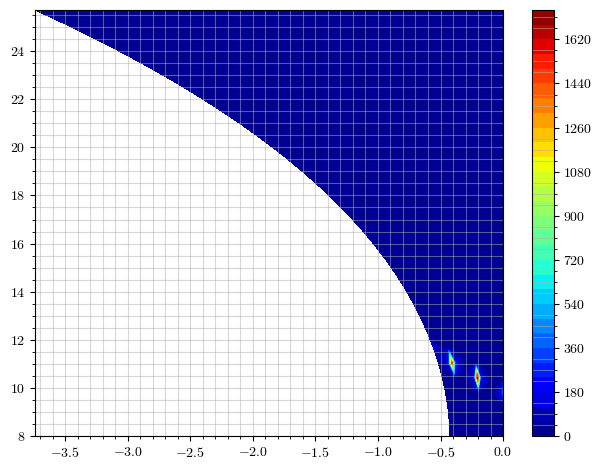

In [ ]:
plt.figure()
plt.contourf(h_dot_op, V_INF_op, dU_dot_vec, cmap="jet", levels=30)
plt.colorbar()
plt.show()

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_42600/738689557.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


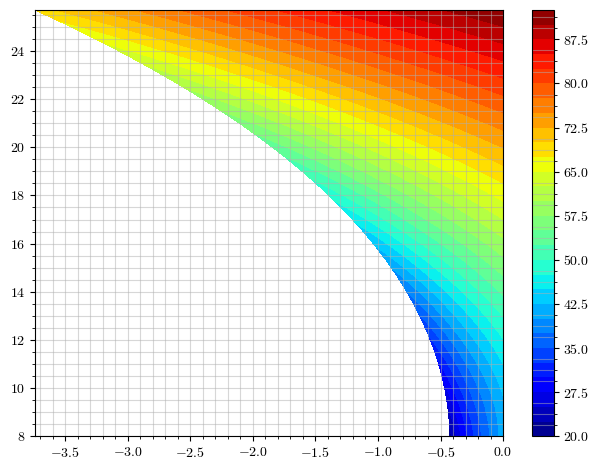

In [ ]:
plt.figure()
plt.contourf(h_dot_op, V_INF_op, N_op, cmap="jet", levels=30)
plt.colorbar()
plt.show()